In [1]:
import autograd.numpy as np
from autograd import jacobian

def F_func(x, u):
    return np.array([x**2, np.sin(u)])

def get_jacobian_func(func, argnum):
    jacobian_func = jacobian(func, argnum=argnum)
    return lambda *args: jacobian_func(*args)

F_x = get_jacobian_func(F_func, argnum=0)
x = 2.0
u = 3.0
F_x_prime = F_x(x, u)
print(F_x_prime)
print(jacobian(F_func, argnum=0)(x,u))



AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
import control
import numpy as np
import matplotlib.pyplot as plt

# Define a MIMO state-space system
A = [[-1, 0.5],
     [0, -2]]
B = [[1, 0],
     [0, 1]]
C = [[1, 0],
     [0, 1]]
D = [[0, 0],
     [0, 0]]
sys_ss = control.ss(A, B, C, D)

# Compute the frequency response
omega = np.logspace(-2, 2, num=100)
mag, phase, omega = control.freqresp(sys_ss, omega)

# Plot the magnitude and phase response
fig, axs = plt.subplots(4, 2, figsize = (10, 18), sharex=True)
i_phase= 0
for i in range(sys_ss.noutputs*2): # times two to capture the magnitude /and/ phase for each input
    if i % 2 == 0:
        i_adj = int(i/2)
        for j in range(sys_ss.ninputs):
            axs[i, j].semilogx(omega, 20 * np.log10(np.abs(mag[i_adj, j, :])))
            axs[i, j].set_title(f'Output {i+1} to Input {j+1}')
            axs[i, j].grid(True)
            axs[i, j].set_xlim([omega[0], omega[-1]])
    else: 
        for j in range(sys_ss.ninputs):
            hld = np.rad2deg(phase[i_phase, j, :])
            axs[i, j].semilogx(omega, np.rad2deg(phase[i_phase, j, :]))
            axs[i, j].set_title(f'Output {i+1} to Input {j+1}')
            axs[i, j].grid(True)
            axs[i, j].set_xlim([omega[0], omega[-1]])
        i_phase = i_phase + 1 
axs[0, 0].set_ylabel('Magnitude (dB)')
axs[1, 0].set_ylabel('Magnitude (dB)')
axs[1, 0].set_xlabel('Frequency (rad/s)')
axs[1, 1].set_xlabel('Frequency (rad/s)')
plt.show()


For i = 0, tolerance was increased to 0.2.
For i = 2, tolerance was increased to 0.4.
For i = 2, tolerance was increased to 0.8.
For i = 2, tolerance was increased to 1.6.
[ 4.24399158e-314  2.43274948e-002 -1.05808846e-002  3.20957070e-002]


C:\Users\logan\AppData\Local\Temp\ipykernel_4736\1204069480.py:24: RuntimeWarning: divide by zero encountered in log10
  axs[i, j].semilogx(omega, 20 * np.log10(np.abs(mag[i_adj, j, :])))
C:\Users\logan\AppData\Local\Temp\ipykernel_4736\1204069480.py:32: RuntimeWarning: divide by zero encountered in log10
  mag_db = 20 * np.log10(np.abs(mag[i_adj, j, :]))


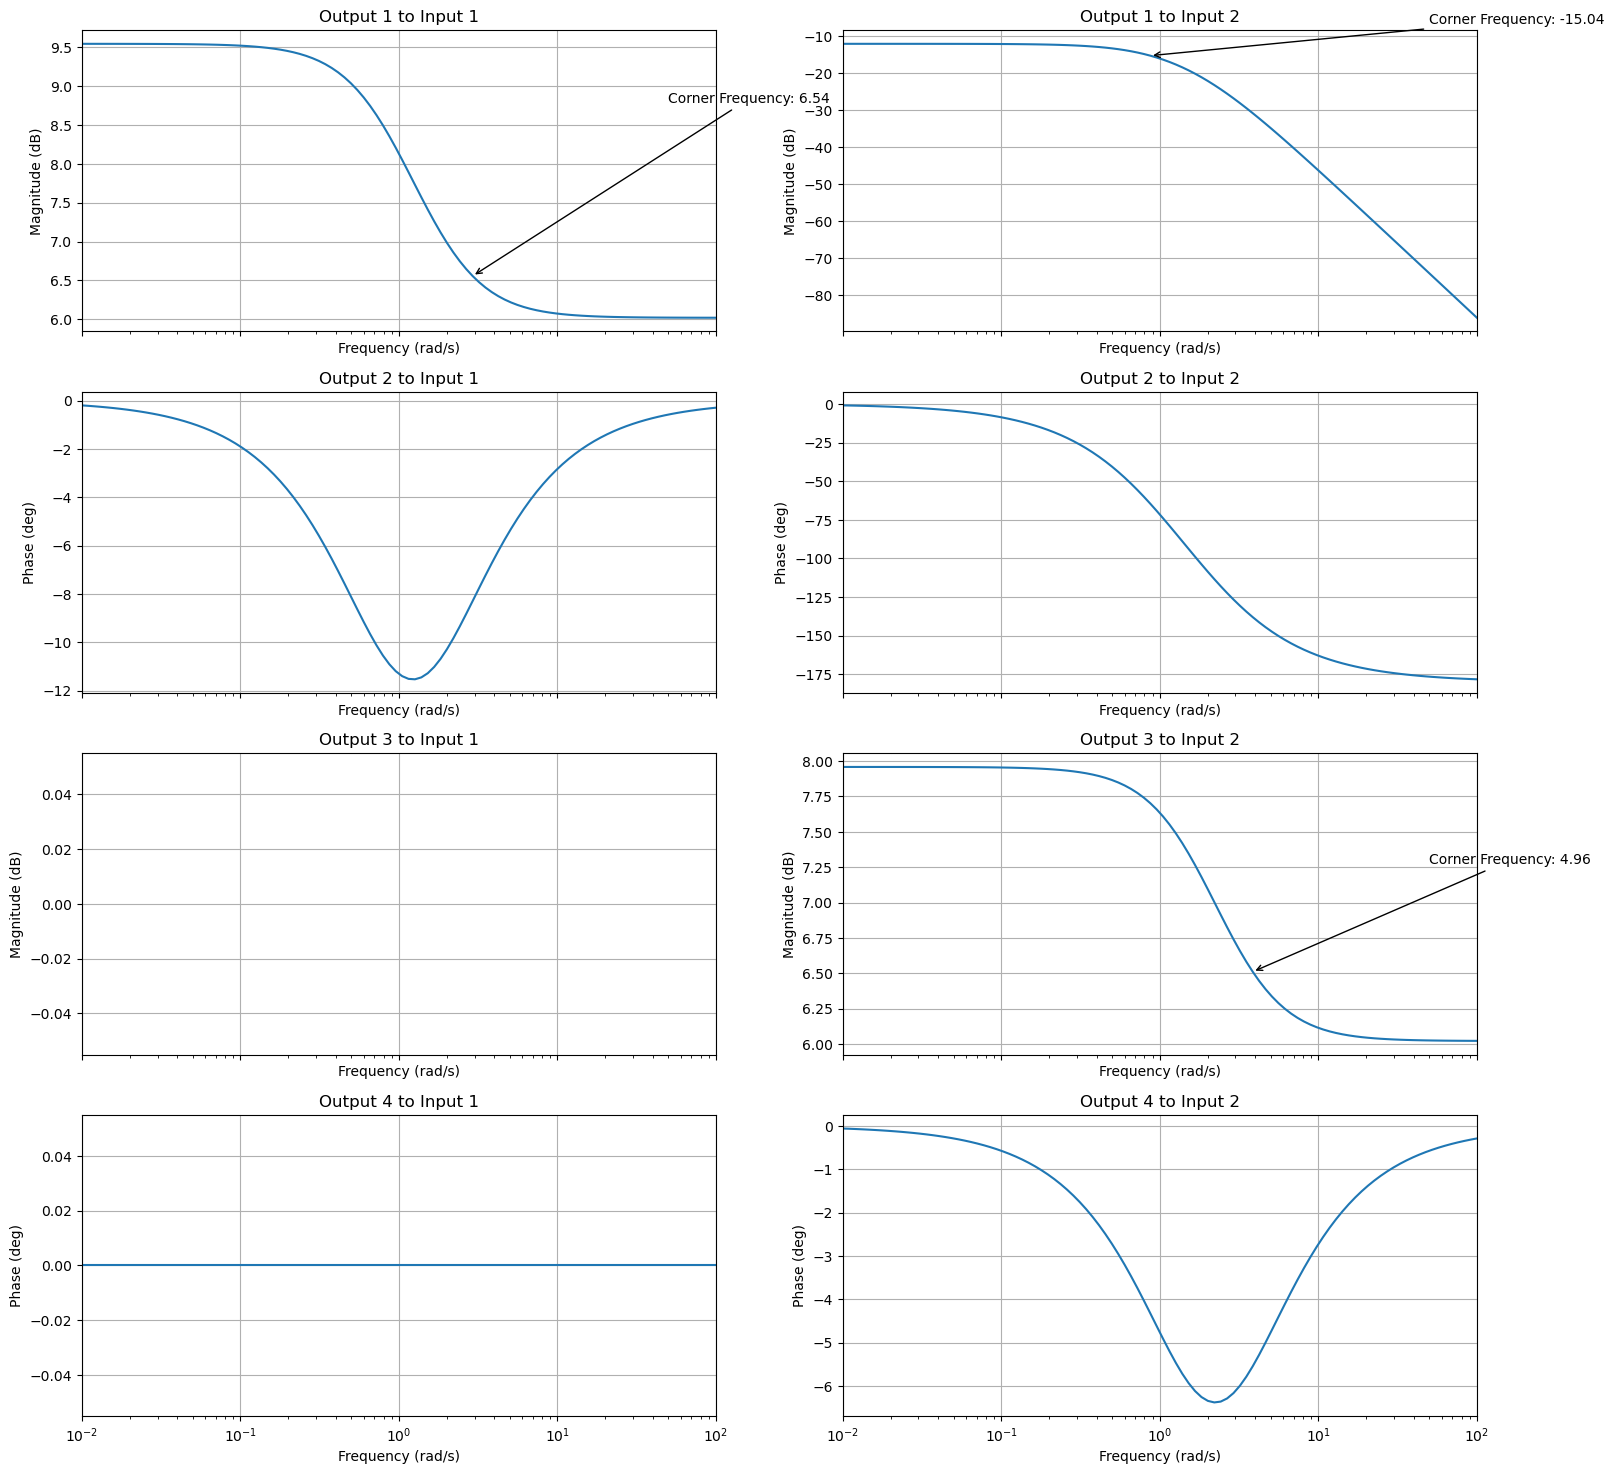

In [2]:
import control
import numpy as np
import matplotlib.pyplot as plt
import math 

def freq_resp(sys_ss: control.NonlinearIOSystem | control.LinearIOSystem, omega: np.ndarray, tol: float, fig_dim_1: int = None, fig_dim_2: int = None):

    mag, phase, omega = control.freqresp(sys_ss, omega)
    tau_arr = np.empty([])

    # Plot the magnitude and phase response
    # TODO: unsafe when providing fig_dim_2 but not fig_dim_1. Make it a tuple? 
    if fig_dim_1 is None:
        fig, axs = plt.subplots(sys_ss.noutputs*2, sys_ss.ninputs, sharex=True)
    else:
        fig, axs = plt.subplots(sys_ss.noutputs*2, sys_ss.ninputs, figsize = (fig_dim_1, fig_dim_2), sharex=True)

    i_phase= 0
    
    for i in range(sys_ss.noutputs*2): # times two to capture the magnitude /and/ phase for each input
        if i % 2 == 0:
            i_adj = int(i/2)
            for j in range(sys_ss.ninputs):
                axs[i, j].semilogx(omega, 20 * np.log10(np.abs(mag[i_adj, j, :])))
                axs[i, j].set_title(f'Output {i+1} to Input {j+1}')
                axs[i, j].set_ylabel('Magnitude (dB)')
                axs[i, j].set_xlabel('Frequency (rad/s)')
                axs[i, j].grid(True)
                axs[i, j].set_xlim([omega[0], omega[-1]])

                # Find the corner frequency
                mag_db = 20 * np.log10(np.abs(mag[i_adj, j, :]))
                max_mag = mag_db[np.argmax(mag_db)]
                if not math.isinf(max_mag): 
                    corner_freq = max_mag - 3 
                    max_attempts = 5
                    attempts = 0
                    label_point = None

                    while attempts < max_attempts and label_point is None:
                        label_point_candidates = np.where((mag_db > corner_freq - tol) & (mag_db < corner_freq + tol))[0]
                        if len(label_point_candidates) > 0:
                            label_point = label_point_candidates[0]
                        else:
                            tol *= 2
                            print(f"For i = {i}, tolerance was increased to {tol}.")
                            attempts += 1

                    if label_point is not None:
                        xlims = axs[i, j].get_xlim()
                        ylims = axs[i, j].get_ylim()
                        axs[i,j].annotate(f'Corner Frequency: {corner_freq:.2f}', xy=(omega[label_point], mag_db[label_point]),
                            xytext=(xlims[0] + (xlims[1]-xlims[0])/2, ylims[1]*0.9), ha='left', va='bottom',
                            arrowprops=dict(arrowstyle='->', color='black'))
                        tau = 1/(2*np.pi*corner_freq)
                        tau_arr = np.append(tau_arr, tau)
                    else:
                        print("Could not find suitable point for annotation.")

        else: 
            for j in range(sys_ss.ninputs):
                hld = np.rad2deg(phase[i_phase, j, :])
                axs[i, j].semilogx(omega, np.rad2deg(phase[i_phase, j, :]))
                axs[i, j].set_title(f'Output {i+1} to Input {j+1}')
                axs[i, j].set_ylabel('Phase (deg)')
                axs[i, j].set_xlabel('Frequency (rad/s)')
                axs[i, j].grid(True)
                axs[i, j].set_xlim([omega[0], omega[-1]])
            i_phase = i_phase + 1 

    return mag, phase, omega, tau_arr, plt

# Define a MIMO state-space system
A = [[-1, 0.5],
     [0, -2]]
B = [[1, 0],
     [0, 1]]
C = [[1, 0],
     [0, 1]]
D = [[2, 0],
     [0, 2]]
sys_ss = control.ss(A, B, C, D)
omega = np.logspace(-2, 2, num=100)

mag, phase, omega, tau_arr, plt = freq_resp(sys_ss, omega, .1, 18, 18)

plt.plot()
print(tau_arr)